<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA6_Phase1/blob/main/EVA6_S7_Dilated_Albumentation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun 18 17:57:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA6_Phase1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'Deep_Learning_EVA6_Phase1' already exists and is not an empty directory.


In [3]:
%cd Deep_Learning_EVA6_Phase1/src
! ls

/content/Deep_Learning_EVA6_Phase1/src
Alb_transforms.py  models.py	README.md    test_loss.py   utilities.py
data		   __pycache__	s7_model.py  train_loss.py


In [4]:
!pip install albumentations==1.0.0

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
cuda = torch.cuda.is_available()
print(f'Albumentations Version : {A.__version__}, Pytorch Version : {torch.__version__}, cuda:{cuda}')

Albumentations Version : 1.0.0, Pytorch Version : 1.9.0+cu102, cuda:True


In [6]:
# Import required src files
import s7_model, utilities, train_loss, test_loss, Alb_transforms

## Calculating mean & std-dev of CIFAR-10 train dataset. This is required for data augmentation

In [7]:
train = datasets.CIFAR10('./data', train=True, download=True)

n  = 0
s  = np.zeros(3)
sq = np.zeros(3)
i  = 0
batchsize = 128
for data, l in train:
  x   = np.array(data)/255                             # Image Normalization 
  s  += x.sum(axis=(0,1))                              # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))               # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n  += x.shape[0]*x.shape[1]                          # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i  += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print(f'No: Of Train Images: {i}, Batch_size : {batchsize}, No: Of Batches:{batches}')
print(f'Channels Mean:{mu}, Channels Stdev:{std}, Total No: of pixels:{n}')


Extracting ./data/cifar-10-python.tar.gz to ./data
No: Of Train Images: 50000, Batch_size : 128, No: Of Batches:390
Channels Mean:[0.49139968 0.48215841 0.44653091], Channels Stdev:[0.24703223 0.24348513 0.26158784], Total No: of pixels:51200000


## Applying data augmentations to train and test dataset

In [7]:
if cuda:
    torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

channels_mean  = [0.49139968, 0.48215841, 0.44653091]
channels_stdev = [0.24703223, 0.24348513, 0.26158784]

test_transforms   = Alb_transforms.Alb_trans([A.Normalize(mean=channels_mean, std=channels_stdev),])
train_transforms  = Alb_transforms.Alb_trans([A.HorizontalFlip(),
                                              A.ShiftScaleRotate(),
                                              A.ToGray(),
                                              A.Normalize(mean=channels_mean, std=channels_stdev),
                                              A.CoarseDropout(max_holes=1, max_height=16, max_width=16,min_holes=1,
                                                              min_height=16,min_width=16,fill_value=channels_mean,mask_fill_value=None),
                                              ])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# train dataloader
trainloader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


## Displaying train-data after applying augmentations. This is to get an idea how images looks like.

In [21]:
# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display
def unnormalize(img):
    for i in range(img.shape[0]):
        img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
    img = img.permute(1, 2, 0)
    return img

images.shape:torch.Size([128, 3, 32, 32]), labels.shape:torch.Size([128])


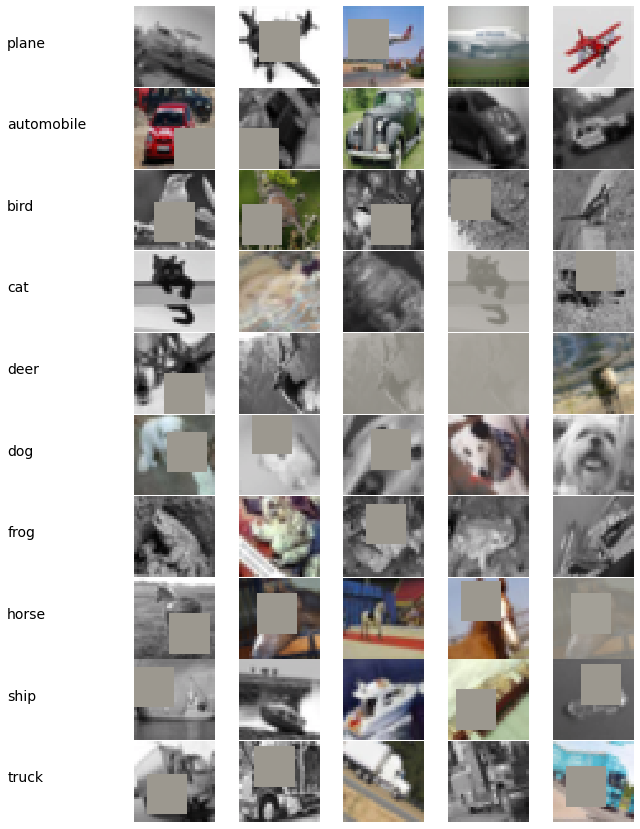

In [22]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()
num_classes    = 10
print(f'images.shape:{images.shape}, labels.shape:{labels.shape}')
# display 5 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col   = 10, 8
num_images = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 5 random images for each class
    ax  = plt.subplot(row, col,class_num*col + 1)                          ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
        plt.subplot(row, col, class_num*col+j+1)
        img = images[idx[j-1]]
        plt.imshow(unnormalize(img), interpolation='none')
        plt.axis('off')
plt.show()

# Model Params


In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [24]:
model = s7_model.S7_CNNModel().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]           1,152
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]           4,096
            Conv2d-8           [-1, 64, 32, 32]           1,152
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]           4,096
           Conv2d-12           [-1, 64, 32, 32]           1,152
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [25]:
print(model)

S7_CNNModel(
  (convblock1A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise1A): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pointwise1A): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (depthwise1B): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pointwise1B): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (depthwise1C): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

# Training and Testing



In [26]:
from torch.optim.lr_scheduler import OneCycleLR

In [39]:
EPOCHS = 200
model = s7_model.S7_CNNModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.8, weight_decay = 0)
scheduler = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCHS)
train_stats, test_stats = utilities.stats_collector(), utilities.stats_collector()
train = train_loss.train_losses(model, device, trainloader, train_stats, optimizer, EPOCHS)
test  = test_loss.test_losses(model, device, testloader, test_stats, EPOCHS)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train.s6_train(epoch, L1_factor=0.0005)
    test.s6_test(epoch)                 

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.7648762464523315 Batch_id=390 Train Accuracy=28.85: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s]

Train set: Epoch : 0/200 Average loss: 0.0000, Train Accuracy: 28.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 0/200 Average loss: 1.5191, Test Accuracy: 43.83
EPOCH: 1


Loss=1.5812040567398071 Batch_id=390 Train Accuracy=39.94: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s]

Train set: Epoch : 1/200 Average loss: 0.0000, Train Accuracy: 39.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 1/200 Average loss: 1.3894, Test Accuracy: 49.75
EPOCH: 2


Loss=1.4195009469985962 Batch_id=390 Train Accuracy=44.80: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 2/200 Average loss: 0.0000, Train Accuracy: 44.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 2/200 Average loss: 1.2005, Test Accuracy: 55.93
EPOCH: 3


Loss=1.2751498222351074 Batch_id=390 Train Accuracy=48.57: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 3/200 Average loss: 0.0000, Train Accuracy: 48.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 3/200 Average loss: 1.1326, Test Accuracy: 58.83
EPOCH: 4


Loss=1.3115357160568237 Batch_id=390 Train Accuracy=50.73: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]

Train set: Epoch : 4/200 Average loss: 0.0000, Train Accuracy: 50.73



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 4/200 Average loss: 1.0722, Test Accuracy: 61.49
EPOCH: 5


Loss=1.3389800786972046 Batch_id=390 Train Accuracy=52.76: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 5/200 Average loss: 0.0000, Train Accuracy: 52.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 5/200 Average loss: 1.0162, Test Accuracy: 63.48
EPOCH: 6


Loss=1.5614184141159058 Batch_id=390 Train Accuracy=54.12: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 6/200 Average loss: 0.0000, Train Accuracy: 54.12



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 6/200 Average loss: 0.9859, Test Accuracy: 64.66
EPOCH: 7


Loss=1.1809290647506714 Batch_id=390 Train Accuracy=55.26: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 7/200 Average loss: 0.0000, Train Accuracy: 55.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 7/200 Average loss: 0.9679, Test Accuracy: 65.21
EPOCH: 8


Loss=1.3448461294174194 Batch_id=390 Train Accuracy=56.71: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 8/200 Average loss: 0.0000, Train Accuracy: 56.71



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 8/200 Average loss: 0.9310, Test Accuracy: 66.92
EPOCH: 9


Loss=1.2805848121643066 Batch_id=390 Train Accuracy=57.44: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 9/200 Average loss: 0.0000, Train Accuracy: 57.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 9/200 Average loss: 0.8684, Test Accuracy: 69.58
EPOCH: 10


Loss=1.1733051538467407 Batch_id=390 Train Accuracy=58.60: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 10/200 Average loss: 0.0000, Train Accuracy: 58.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 10/200 Average loss: 0.8632, Test Accuracy: 69.36
EPOCH: 11


Loss=1.2230253219604492 Batch_id=390 Train Accuracy=59.31: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 11/200 Average loss: 0.0000, Train Accuracy: 59.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 11/200 Average loss: 0.8588, Test Accuracy: 69.3
EPOCH: 12


Loss=1.1932365894317627 Batch_id=390 Train Accuracy=60.38: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 12/200 Average loss: 0.0000, Train Accuracy: 60.38



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 12/200 Average loss: 0.7965, Test Accuracy: 71.82
EPOCH: 13


Loss=0.9259686470031738 Batch_id=390 Train Accuracy=61.11: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 13/200 Average loss: 0.0000, Train Accuracy: 61.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 13/200 Average loss: 0.7851, Test Accuracy: 72.34
EPOCH: 14


Loss=1.1568543910980225 Batch_id=390 Train Accuracy=61.53: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 14/200 Average loss: 0.0000, Train Accuracy: 61.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 14/200 Average loss: 0.7906, Test Accuracy: 72.44
EPOCH: 15


Loss=1.0246498584747314 Batch_id=390 Train Accuracy=62.31: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 15/200 Average loss: 0.0000, Train Accuracy: 62.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 15/200 Average loss: 0.7729, Test Accuracy: 72.62
EPOCH: 16


Loss=1.3387190103530884 Batch_id=390 Train Accuracy=62.93: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 16/200 Average loss: 0.0000, Train Accuracy: 62.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 16/200 Average loss: 0.7798, Test Accuracy: 72.75
EPOCH: 17


Loss=1.2320265769958496 Batch_id=390 Train Accuracy=63.15: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 17/200 Average loss: 0.0000, Train Accuracy: 63.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 17/200 Average loss: 0.7239, Test Accuracy: 74.64
EPOCH: 18


Loss=1.1354305744171143 Batch_id=390 Train Accuracy=63.52: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 18/200 Average loss: 0.0000, Train Accuracy: 63.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 18/200 Average loss: 0.7205, Test Accuracy: 74.83
EPOCH: 19


Loss=1.181518316268921 Batch_id=390 Train Accuracy=64.41: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 19/200 Average loss: 0.0000, Train Accuracy: 64.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 19/200 Average loss: 0.7148, Test Accuracy: 75.11
EPOCH: 20


Loss=1.1672204732894897 Batch_id=390 Train Accuracy=64.76: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 20/200 Average loss: 0.0000, Train Accuracy: 64.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 20/200 Average loss: 0.7164, Test Accuracy: 74.87
EPOCH: 21


Loss=0.8974834680557251 Batch_id=390 Train Accuracy=64.87: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 21/200 Average loss: 0.0000, Train Accuracy: 64.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 21/200 Average loss: 0.6933, Test Accuracy: 75.92
EPOCH: 22


Loss=1.1093101501464844 Batch_id=390 Train Accuracy=65.33: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 22/200 Average loss: 0.0000, Train Accuracy: 65.33



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 22/200 Average loss: 0.6844, Test Accuracy: 76.29
EPOCH: 23


Loss=0.9279069900512695 Batch_id=390 Train Accuracy=66.05: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 23/200 Average loss: 0.0000, Train Accuracy: 66.05



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 23/200 Average loss: 0.6720, Test Accuracy: 76.52
EPOCH: 24


Loss=0.9359261393547058 Batch_id=390 Train Accuracy=65.88: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 24/200 Average loss: 0.0000, Train Accuracy: 65.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 24/200 Average loss: 0.6638, Test Accuracy: 76.75
EPOCH: 25


Loss=0.9560215473175049 Batch_id=390 Train Accuracy=66.69: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 25/200 Average loss: 0.0000, Train Accuracy: 66.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 25/200 Average loss: 0.6628, Test Accuracy: 76.7
EPOCH: 26


Loss=0.9423319101333618 Batch_id=390 Train Accuracy=66.93: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 26/200 Average loss: 0.0000, Train Accuracy: 66.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 26/200 Average loss: 0.6643, Test Accuracy: 76.71
EPOCH: 27


Loss=0.9698487520217896 Batch_id=390 Train Accuracy=67.02: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 27/200 Average loss: 0.0000, Train Accuracy: 67.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 27/200 Average loss: 0.6393, Test Accuracy: 77.51
EPOCH: 28


Loss=0.9953485727310181 Batch_id=390 Train Accuracy=67.64: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 28/200 Average loss: 0.0000, Train Accuracy: 67.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 28/200 Average loss: 0.6464, Test Accuracy: 77.46
EPOCH: 29


Loss=0.8080469965934753 Batch_id=390 Train Accuracy=67.41: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 29/200 Average loss: 0.0000, Train Accuracy: 67.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 29/200 Average loss: 0.6343, Test Accuracy: 77.99
EPOCH: 30


Loss=1.137485146522522 Batch_id=390 Train Accuracy=68.14: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 30/200 Average loss: 0.0000, Train Accuracy: 68.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 30/200 Average loss: 0.6411, Test Accuracy: 77.82
EPOCH: 31


Loss=1.0508904457092285 Batch_id=390 Train Accuracy=68.06: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 31/200 Average loss: 0.0000, Train Accuracy: 68.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 31/200 Average loss: 0.6277, Test Accuracy: 78.05
EPOCH: 32


Loss=0.9572073817253113 Batch_id=390 Train Accuracy=68.37: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 32/200 Average loss: 0.0000, Train Accuracy: 68.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 32/200 Average loss: 0.6230, Test Accuracy: 78.5
EPOCH: 33


Loss=0.8222858905792236 Batch_id=390 Train Accuracy=68.54: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 33/200 Average loss: 0.0000, Train Accuracy: 68.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 33/200 Average loss: 0.6254, Test Accuracy: 78.14
EPOCH: 34


Loss=0.8593858480453491 Batch_id=390 Train Accuracy=68.87: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 34/200 Average loss: 0.0000, Train Accuracy: 68.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 34/200 Average loss: 0.6272, Test Accuracy: 78.45
EPOCH: 35


Loss=0.7141827344894409 Batch_id=390 Train Accuracy=69.26: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 35/200 Average loss: 0.0000, Train Accuracy: 69.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 35/200 Average loss: 0.6008, Test Accuracy: 78.86
EPOCH: 36


Loss=0.8852272033691406 Batch_id=390 Train Accuracy=69.17: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 36/200 Average loss: 0.0000, Train Accuracy: 69.17



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 36/200 Average loss: 0.6122, Test Accuracy: 78.5
EPOCH: 37


Loss=0.9722157120704651 Batch_id=390 Train Accuracy=69.44: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 37/200 Average loss: 0.0000, Train Accuracy: 69.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 37/200 Average loss: 0.5811, Test Accuracy: 79.7
EPOCH: 38


Loss=0.7447943687438965 Batch_id=390 Train Accuracy=69.81: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 38/200 Average loss: 0.0000, Train Accuracy: 69.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 38/200 Average loss: 0.5842, Test Accuracy: 79.6
EPOCH: 39


Loss=0.848170280456543 Batch_id=390 Train Accuracy=70.21: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 39/200 Average loss: 0.0000, Train Accuracy: 70.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 39/200 Average loss: 0.5889, Test Accuracy: 79.67
EPOCH: 40


Loss=0.6277278065681458 Batch_id=390 Train Accuracy=70.35: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 40/200 Average loss: 0.0000, Train Accuracy: 70.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 40/200 Average loss: 0.5948, Test Accuracy: 79.59
EPOCH: 41


Loss=0.6471081376075745 Batch_id=390 Train Accuracy=70.47: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 41/200 Average loss: 0.0000, Train Accuracy: 70.47



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 41/200 Average loss: 0.5588, Test Accuracy: 80.95
EPOCH: 42


Loss=0.7684924006462097 Batch_id=390 Train Accuracy=70.50: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 42/200 Average loss: 0.0000, Train Accuracy: 70.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 42/200 Average loss: 0.5583, Test Accuracy: 80.5
EPOCH: 43


Loss=0.8167582154273987 Batch_id=390 Train Accuracy=70.65: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 43/200 Average loss: 0.0000, Train Accuracy: 70.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 43/200 Average loss: 0.5634, Test Accuracy: 80.57
EPOCH: 44


Loss=0.8606036901473999 Batch_id=390 Train Accuracy=71.09: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 44/200 Average loss: 0.0000, Train Accuracy: 71.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 44/200 Average loss: 0.5688, Test Accuracy: 80.26
EPOCH: 45


Loss=0.9697200059890747 Batch_id=390 Train Accuracy=71.13: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 45/200 Average loss: 0.0000, Train Accuracy: 71.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 45/200 Average loss: 0.5539, Test Accuracy: 80.92
EPOCH: 46


Loss=0.9813822507858276 Batch_id=390 Train Accuracy=70.96: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 46/200 Average loss: 0.0000, Train Accuracy: 70.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 46/200 Average loss: 0.5591, Test Accuracy: 80.91
EPOCH: 47


Loss=0.5187575817108154 Batch_id=390 Train Accuracy=71.29: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 47/200 Average loss: 0.0000, Train Accuracy: 71.29



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 47/200 Average loss: 0.5328, Test Accuracy: 81.63
EPOCH: 48


Loss=0.8367276787757874 Batch_id=390 Train Accuracy=71.37: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 48/200 Average loss: 0.0000, Train Accuracy: 71.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 48/200 Average loss: 0.5386, Test Accuracy: 81.73
EPOCH: 49


Loss=0.7257537841796875 Batch_id=390 Train Accuracy=71.59: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 49/200 Average loss: 0.0000, Train Accuracy: 71.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 49/200 Average loss: 0.5646, Test Accuracy: 80.87
EPOCH: 50


Loss=0.8480237126350403 Batch_id=390 Train Accuracy=71.80: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 50/200 Average loss: 0.0000, Train Accuracy: 71.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 50/200 Average loss: 0.5621, Test Accuracy: 81.11
EPOCH: 51


Loss=0.8804602026939392 Batch_id=390 Train Accuracy=71.81: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 51/200 Average loss: 0.0000, Train Accuracy: 71.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 51/200 Average loss: 0.5588, Test Accuracy: 80.55
EPOCH: 52


Loss=0.6757911443710327 Batch_id=390 Train Accuracy=71.86: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 52/200 Average loss: 0.0000, Train Accuracy: 71.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 52/200 Average loss: 0.5373, Test Accuracy: 81.71
EPOCH: 53


Loss=0.7157280445098877 Batch_id=390 Train Accuracy=71.65: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 53/200 Average loss: 0.0000, Train Accuracy: 71.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 53/200 Average loss: 0.5344, Test Accuracy: 81.48
EPOCH: 54


Loss=0.7669557929039001 Batch_id=390 Train Accuracy=72.50: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 54/200 Average loss: 0.0000, Train Accuracy: 72.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 54/200 Average loss: 0.5356, Test Accuracy: 81.65
EPOCH: 55


Loss=0.8148732781410217 Batch_id=390 Train Accuracy=72.60: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 55/200 Average loss: 0.0000, Train Accuracy: 72.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 55/200 Average loss: 0.5217, Test Accuracy: 82.31
EPOCH: 56


Loss=0.6974123120307922 Batch_id=390 Train Accuracy=72.61: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 56/200 Average loss: 0.0000, Train Accuracy: 72.61



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 56/200 Average loss: 0.5212, Test Accuracy: 82.02
EPOCH: 57


Loss=0.8134921789169312 Batch_id=390 Train Accuracy=72.79: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 57/200 Average loss: 0.0000, Train Accuracy: 72.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 57/200 Average loss: 0.5155, Test Accuracy: 82.64
EPOCH: 58


Loss=0.7740365266799927 Batch_id=390 Train Accuracy=72.66: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 58/200 Average loss: 0.0000, Train Accuracy: 72.66



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 58/200 Average loss: 0.5268, Test Accuracy: 82.07
EPOCH: 59


Loss=1.0611546039581299 Batch_id=390 Train Accuracy=73.01: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 59/200 Average loss: 0.0000, Train Accuracy: 73.01



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 59/200 Average loss: 0.5063, Test Accuracy: 83.06
EPOCH: 60


Loss=0.7064898610115051 Batch_id=390 Train Accuracy=72.84: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]

Train set: Epoch : 60/200 Average loss: 0.0000, Train Accuracy: 72.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 60/200 Average loss: 0.5447, Test Accuracy: 81.14
EPOCH: 61


Loss=0.7252072095870972 Batch_id=390 Train Accuracy=72.93: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 61/200 Average loss: 0.0000, Train Accuracy: 72.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 61/200 Average loss: 0.5233, Test Accuracy: 82.41
EPOCH: 62


Loss=0.6676097512245178 Batch_id=390 Train Accuracy=73.62: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 62/200 Average loss: 0.0000, Train Accuracy: 73.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 62/200 Average loss: 0.5055, Test Accuracy: 82.61
EPOCH: 63


Loss=0.9698499441146851 Batch_id=390 Train Accuracy=73.13: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 63/200 Average loss: 0.0000, Train Accuracy: 73.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 63/200 Average loss: 0.5034, Test Accuracy: 82.99
EPOCH: 64


Loss=0.7398738265037537 Batch_id=390 Train Accuracy=73.32: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 64/200 Average loss: 0.0000, Train Accuracy: 73.32



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 64/200 Average loss: 0.5082, Test Accuracy: 82.76
EPOCH: 65


Loss=0.7594175934791565 Batch_id=390 Train Accuracy=73.39: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 65/200 Average loss: 0.0000, Train Accuracy: 73.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 65/200 Average loss: 0.5181, Test Accuracy: 82.47
EPOCH: 66


Loss=0.6084271669387817 Batch_id=390 Train Accuracy=73.42: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 66/200 Average loss: 0.0000, Train Accuracy: 73.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 66/200 Average loss: 0.4849, Test Accuracy: 83.68
EPOCH: 67


Loss=0.6739403009414673 Batch_id=390 Train Accuracy=73.53: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]

Train set: Epoch : 67/200 Average loss: 0.0000, Train Accuracy: 73.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 67/200 Average loss: 0.4860, Test Accuracy: 82.99
EPOCH: 68


Loss=0.8395785689353943 Batch_id=390 Train Accuracy=73.74: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 68/200 Average loss: 0.0000, Train Accuracy: 73.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 68/200 Average loss: 0.5060, Test Accuracy: 82.47
EPOCH: 69


Loss=0.8379548192024231 Batch_id=390 Train Accuracy=73.75: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 69/200 Average loss: 0.0000, Train Accuracy: 73.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 69/200 Average loss: 0.4934, Test Accuracy: 83.31
EPOCH: 70


Loss=0.8060604929924011 Batch_id=390 Train Accuracy=73.76: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 70/200 Average loss: 0.0000, Train Accuracy: 73.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 70/200 Average loss: 0.5174, Test Accuracy: 82.62
EPOCH: 71


Loss=0.8546150326728821 Batch_id=390 Train Accuracy=73.82: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 71/200 Average loss: 0.0000, Train Accuracy: 73.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 71/200 Average loss: 0.4895, Test Accuracy: 83.31
EPOCH: 72


Loss=0.8896656632423401 Batch_id=390 Train Accuracy=74.01: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 72/200 Average loss: 0.0000, Train Accuracy: 74.01



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 72/200 Average loss: 0.4990, Test Accuracy: 83.12
EPOCH: 73


Loss=0.8279810547828674 Batch_id=390 Train Accuracy=73.91: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 73/200 Average loss: 0.0000, Train Accuracy: 73.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 73/200 Average loss: 0.4871, Test Accuracy: 83.36
EPOCH: 74


Loss=0.7110768556594849 Batch_id=390 Train Accuracy=74.13: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 74/200 Average loss: 0.0000, Train Accuracy: 74.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 74/200 Average loss: 0.4895, Test Accuracy: 83.41
EPOCH: 75


Loss=1.189507007598877 Batch_id=390 Train Accuracy=74.14: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 75/200 Average loss: 0.0000, Train Accuracy: 74.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 75/200 Average loss: 0.4850, Test Accuracy: 83.79
EPOCH: 76


Loss=0.6428901553153992 Batch_id=390 Train Accuracy=74.15: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 76/200 Average loss: 0.0000, Train Accuracy: 74.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 76/200 Average loss: 0.4885, Test Accuracy: 83.67
EPOCH: 77


Loss=0.6824919581413269 Batch_id=390 Train Accuracy=74.57: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 77/200 Average loss: 0.0000, Train Accuracy: 74.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 77/200 Average loss: 0.4903, Test Accuracy: 83.35
EPOCH: 78


Loss=0.6788821816444397 Batch_id=390 Train Accuracy=74.60: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 78/200 Average loss: 0.0000, Train Accuracy: 74.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 78/200 Average loss: 0.4874, Test Accuracy: 83.64
EPOCH: 79


Loss=0.7545822858810425 Batch_id=390 Train Accuracy=74.59: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 79/200 Average loss: 0.0000, Train Accuracy: 74.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 79/200 Average loss: 0.4822, Test Accuracy: 83.56
EPOCH: 80


Loss=0.6541188359260559 Batch_id=390 Train Accuracy=74.89: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 80/200 Average loss: 0.0000, Train Accuracy: 74.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 80/200 Average loss: 0.4769, Test Accuracy: 83.87
EPOCH: 81


Loss=0.887240469455719 Batch_id=390 Train Accuracy=74.85: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 81/200 Average loss: 0.0000, Train Accuracy: 74.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 81/200 Average loss: 0.4804, Test Accuracy: 83.72
EPOCH: 82


Loss=0.533538281917572 Batch_id=390 Train Accuracy=74.62: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 82/200 Average loss: 0.0000, Train Accuracy: 74.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 82/200 Average loss: 0.4754, Test Accuracy: 83.73
EPOCH: 83


Loss=0.7156581878662109 Batch_id=390 Train Accuracy=74.99: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 83/200 Average loss: 0.0000, Train Accuracy: 74.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 83/200 Average loss: 0.4663, Test Accuracy: 84.03
EPOCH: 84


Loss=0.843777596950531 Batch_id=390 Train Accuracy=74.90: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 84/200 Average loss: 0.0000, Train Accuracy: 74.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 84/200 Average loss: 0.4589, Test Accuracy: 84.13
EPOCH: 85


Loss=0.8981393575668335 Batch_id=390 Train Accuracy=75.22: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 85/200 Average loss: 0.0000, Train Accuracy: 75.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 85/200 Average loss: 0.4833, Test Accuracy: 83.82
EPOCH: 86


Loss=0.8011788725852966 Batch_id=390 Train Accuracy=75.22: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 86/200 Average loss: 0.0000, Train Accuracy: 75.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 86/200 Average loss: 0.4652, Test Accuracy: 83.78
EPOCH: 87


Loss=0.9063002467155457 Batch_id=390 Train Accuracy=75.08: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 87/200 Average loss: 0.0000, Train Accuracy: 75.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 87/200 Average loss: 0.4648, Test Accuracy: 84.09
EPOCH: 88


Loss=0.6730993390083313 Batch_id=390 Train Accuracy=75.24: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 88/200 Average loss: 0.0000, Train Accuracy: 75.24



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 88/200 Average loss: 0.4921, Test Accuracy: 83.34
EPOCH: 89


Loss=0.9325119853019714 Batch_id=390 Train Accuracy=75.39: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 89/200 Average loss: 0.0000, Train Accuracy: 75.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 89/200 Average loss: 0.4734, Test Accuracy: 83.86
EPOCH: 90


Loss=0.6205345392227173 Batch_id=390 Train Accuracy=75.51: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 90/200 Average loss: 0.0000, Train Accuracy: 75.51



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 90/200 Average loss: 0.4634, Test Accuracy: 84.19
EPOCH: 91


Loss=0.7206959128379822 Batch_id=390 Train Accuracy=75.41: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 91/200 Average loss: 0.0000, Train Accuracy: 75.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 91/200 Average loss: 0.4597, Test Accuracy: 84.09
EPOCH: 92


Loss=0.6570225358009338 Batch_id=390 Train Accuracy=75.17: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 92/200 Average loss: 0.0000, Train Accuracy: 75.17



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 92/200 Average loss: 0.4706, Test Accuracy: 83.9
EPOCH: 93


Loss=0.7942830920219421 Batch_id=390 Train Accuracy=75.44: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 93/200 Average loss: 0.0000, Train Accuracy: 75.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 93/200 Average loss: 0.4628, Test Accuracy: 84.41
EPOCH: 94


Loss=0.7446745038032532 Batch_id=390 Train Accuracy=75.33: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 94/200 Average loss: 0.0000, Train Accuracy: 75.33



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 94/200 Average loss: 0.4595, Test Accuracy: 84.3
EPOCH: 95


Loss=0.7952355146408081 Batch_id=390 Train Accuracy=75.66: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 95/200 Average loss: 0.0000, Train Accuracy: 75.66



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 95/200 Average loss: 0.4656, Test Accuracy: 84.2
EPOCH: 96


Loss=0.690268337726593 Batch_id=390 Train Accuracy=75.59: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 96/200 Average loss: 0.0000, Train Accuracy: 75.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 96/200 Average loss: 0.4569, Test Accuracy: 84.89
EPOCH: 97


Loss=0.6942017078399658 Batch_id=390 Train Accuracy=75.55: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 97/200 Average loss: 0.0000, Train Accuracy: 75.55



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 97/200 Average loss: 0.4585, Test Accuracy: 84.64
EPOCH: 98


Loss=0.46693360805511475 Batch_id=390 Train Accuracy=75.57: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 98/200 Average loss: 0.0000, Train Accuracy: 75.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 98/200 Average loss: 0.4522, Test Accuracy: 84.39
EPOCH: 99


Loss=0.7021059393882751 Batch_id=390 Train Accuracy=75.77: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 99/200 Average loss: 0.0000, Train Accuracy: 75.77



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 99/200 Average loss: 0.4508, Test Accuracy: 84.79
EPOCH: 100


Loss=0.5891910791397095 Batch_id=390 Train Accuracy=75.68: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 100/200 Average loss: 0.0000, Train Accuracy: 75.68



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 100/200 Average loss: 0.4408, Test Accuracy: 84.68
EPOCH: 101


Loss=0.7375657558441162 Batch_id=390 Train Accuracy=75.88: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 101/200 Average loss: 0.0000, Train Accuracy: 75.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 101/200 Average loss: 0.4593, Test Accuracy: 84.3
EPOCH: 102


Loss=0.6305214762687683 Batch_id=390 Train Accuracy=75.79: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 102/200 Average loss: 0.0000, Train Accuracy: 75.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 102/200 Average loss: 0.4475, Test Accuracy: 84.84
EPOCH: 103


Loss=0.7204335331916809 Batch_id=390 Train Accuracy=75.94: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 103/200 Average loss: 0.0000, Train Accuracy: 75.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 103/200 Average loss: 0.4746, Test Accuracy: 83.94
EPOCH: 104


Loss=1.022404670715332 Batch_id=390 Train Accuracy=75.79: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 104/200 Average loss: 0.0000, Train Accuracy: 75.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 104/200 Average loss: 0.4385, Test Accuracy: 85.08
EPOCH: 105


Loss=0.6716933846473694 Batch_id=390 Train Accuracy=76.13: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 105/200 Average loss: 0.0000, Train Accuracy: 76.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 105/200 Average loss: 0.4624, Test Accuracy: 84.09
EPOCH: 106


Loss=0.8508724570274353 Batch_id=390 Train Accuracy=75.95: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 106/200 Average loss: 0.0000, Train Accuracy: 75.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 106/200 Average loss: 0.4448, Test Accuracy: 85.08
EPOCH: 107


Loss=0.6836787462234497 Batch_id=390 Train Accuracy=76.29: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 107/200 Average loss: 0.0000, Train Accuracy: 76.29



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 107/200 Average loss: 0.4470, Test Accuracy: 84.63
EPOCH: 108


Loss=0.8151429295539856 Batch_id=390 Train Accuracy=76.17: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 108/200 Average loss: 0.0000, Train Accuracy: 76.17



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 108/200 Average loss: 0.4535, Test Accuracy: 84.64
EPOCH: 109


Loss=0.6951369643211365 Batch_id=390 Train Accuracy=76.34: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 109/200 Average loss: 0.0000, Train Accuracy: 76.34



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 109/200 Average loss: 0.4362, Test Accuracy: 85.04
EPOCH: 110


Loss=0.7538046836853027 Batch_id=390 Train Accuracy=75.82: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 110/200 Average loss: 0.0000, Train Accuracy: 75.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 110/200 Average loss: 0.4400, Test Accuracy: 84.82
EPOCH: 111


Loss=0.7612151503562927 Batch_id=390 Train Accuracy=76.28: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 111/200 Average loss: 0.0000, Train Accuracy: 76.28



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 111/200 Average loss: 0.4395, Test Accuracy: 85.17
EPOCH: 112


Loss=0.40947961807250977 Batch_id=390 Train Accuracy=76.45: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 112/200 Average loss: 0.0000, Train Accuracy: 76.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 112/200 Average loss: 0.4492, Test Accuracy: 84.49
EPOCH: 113


Loss=0.7651621103286743 Batch_id=390 Train Accuracy=76.56: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 113/200 Average loss: 0.0000, Train Accuracy: 76.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 113/200 Average loss: 0.4284, Test Accuracy: 85.67
EPOCH: 114


Loss=0.6391496658325195 Batch_id=390 Train Accuracy=76.46: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 114/200 Average loss: 0.0000, Train Accuracy: 76.46



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 114/200 Average loss: 0.4327, Test Accuracy: 85.44
EPOCH: 115


Loss=0.5180981755256653 Batch_id=390 Train Accuracy=76.30: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 115/200 Average loss: 0.0000, Train Accuracy: 76.3



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 115/200 Average loss: 0.4411, Test Accuracy: 84.95
EPOCH: 116


Loss=0.561331570148468 Batch_id=390 Train Accuracy=76.64: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 116/200 Average loss: 0.0000, Train Accuracy: 76.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 116/200 Average loss: 0.4462, Test Accuracy: 85.04
EPOCH: 117


Loss=0.6190299391746521 Batch_id=390 Train Accuracy=76.62: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 117/200 Average loss: 0.0000, Train Accuracy: 76.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 117/200 Average loss: 0.4372, Test Accuracy: 84.88
EPOCH: 118


Loss=0.4393768310546875 Batch_id=390 Train Accuracy=76.86: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 118/200 Average loss: 0.0000, Train Accuracy: 76.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 118/200 Average loss: 0.4409, Test Accuracy: 85.14
EPOCH: 119


Loss=0.5499429702758789 Batch_id=390 Train Accuracy=76.76: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 119/200 Average loss: 0.0000, Train Accuracy: 76.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 119/200 Average loss: 0.4364, Test Accuracy: 85.19
EPOCH: 120


Loss=0.7219251394271851 Batch_id=390 Train Accuracy=76.68: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 120/200 Average loss: 0.0000, Train Accuracy: 76.68



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 120/200 Average loss: 0.4418, Test Accuracy: 84.97
EPOCH: 121


Loss=0.7963812351226807 Batch_id=390 Train Accuracy=76.76: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 121/200 Average loss: 0.0000, Train Accuracy: 76.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 121/200 Average loss: 0.4362, Test Accuracy: 84.95
EPOCH: 122


Loss=0.6931431889533997 Batch_id=390 Train Accuracy=76.67: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 122/200 Average loss: 0.0000, Train Accuracy: 76.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 122/200 Average loss: 0.4385, Test Accuracy: 85.0
EPOCH: 123


Loss=0.96351158618927 Batch_id=390 Train Accuracy=76.85: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 123/200 Average loss: 0.0000, Train Accuracy: 76.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 123/200 Average loss: 0.4323, Test Accuracy: 85.31
EPOCH: 124


Loss=0.8361195921897888 Batch_id=390 Train Accuracy=76.99: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 124/200 Average loss: 0.0000, Train Accuracy: 76.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 124/200 Average loss: 0.4348, Test Accuracy: 85.21
EPOCH: 125


Loss=0.4980139434337616 Batch_id=390 Train Accuracy=76.87: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 125/200 Average loss: 0.0000, Train Accuracy: 76.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 125/200 Average loss: 0.4292, Test Accuracy: 85.13
EPOCH: 126


Loss=0.7379947304725647 Batch_id=390 Train Accuracy=76.93: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 126/200 Average loss: 0.0000, Train Accuracy: 76.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 126/200 Average loss: 0.4261, Test Accuracy: 85.14
EPOCH: 127


Loss=0.6668202877044678 Batch_id=390 Train Accuracy=76.97: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 127/200 Average loss: 0.0000, Train Accuracy: 76.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 127/200 Average loss: 0.4293, Test Accuracy: 85.34
EPOCH: 128


Loss=0.562361478805542 Batch_id=390 Train Accuracy=77.05: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 128/200 Average loss: 0.0000, Train Accuracy: 77.05



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 128/200 Average loss: 0.4285, Test Accuracy: 85.4
EPOCH: 129


Loss=0.9410848021507263 Batch_id=390 Train Accuracy=77.06: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 129/200 Average loss: 0.0000, Train Accuracy: 77.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 129/200 Average loss: 0.4271, Test Accuracy: 85.58
EPOCH: 130


Loss=0.8330866694450378 Batch_id=390 Train Accuracy=76.87: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 130/200 Average loss: 0.0000, Train Accuracy: 76.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 130/200 Average loss: 0.4387, Test Accuracy: 85.13
EPOCH: 131


Loss=0.6935567259788513 Batch_id=390 Train Accuracy=77.23: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 131/200 Average loss: 0.0000, Train Accuracy: 77.23



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 131/200 Average loss: 0.4307, Test Accuracy: 85.46
EPOCH: 132


Loss=0.6112217903137207 Batch_id=390 Train Accuracy=77.10: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 132/200 Average loss: 0.0000, Train Accuracy: 77.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 132/200 Average loss: 0.4286, Test Accuracy: 85.49
EPOCH: 133


Loss=0.6155194640159607 Batch_id=390 Train Accuracy=77.21: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 133/200 Average loss: 0.0000, Train Accuracy: 77.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 133/200 Average loss: 0.4180, Test Accuracy: 85.74
EPOCH: 134


Loss=0.7253182530403137 Batch_id=390 Train Accuracy=77.16: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 134/200 Average loss: 0.0000, Train Accuracy: 77.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 134/200 Average loss: 0.4125, Test Accuracy: 85.96
EPOCH: 135


Loss=0.6928255558013916 Batch_id=390 Train Accuracy=77.45: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 135/200 Average loss: 0.0000, Train Accuracy: 77.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 135/200 Average loss: 0.4339, Test Accuracy: 85.28
EPOCH: 136


Loss=0.5165780186653137 Batch_id=390 Train Accuracy=77.17: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 136/200 Average loss: 0.0000, Train Accuracy: 77.17



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 136/200 Average loss: 0.4234, Test Accuracy: 85.44
EPOCH: 137


Loss=0.862305760383606 Batch_id=390 Train Accuracy=77.14: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 137/200 Average loss: 0.0000, Train Accuracy: 77.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 137/200 Average loss: 0.4207, Test Accuracy: 85.53
EPOCH: 138


Loss=0.5646740794181824 Batch_id=390 Train Accuracy=77.49: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 138/200 Average loss: 0.0000, Train Accuracy: 77.49



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 138/200 Average loss: 0.4235, Test Accuracy: 85.65
EPOCH: 139


Loss=0.7991652488708496 Batch_id=390 Train Accuracy=77.64: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 139/200 Average loss: 0.0000, Train Accuracy: 77.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 139/200 Average loss: 0.4231, Test Accuracy: 85.52
EPOCH: 140


Loss=0.5609850287437439 Batch_id=390 Train Accuracy=77.31: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 140/200 Average loss: 0.0000, Train Accuracy: 77.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 140/200 Average loss: 0.4275, Test Accuracy: 85.3
EPOCH: 141


Loss=0.4976975619792938 Batch_id=390 Train Accuracy=77.30: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 141/200 Average loss: 0.0000, Train Accuracy: 77.3



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 141/200 Average loss: 0.4193, Test Accuracy: 85.86
EPOCH: 142


Loss=0.6573691368103027 Batch_id=390 Train Accuracy=77.29: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 142/200 Average loss: 0.0000, Train Accuracy: 77.29



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 142/200 Average loss: 0.4219, Test Accuracy: 85.84
EPOCH: 143


Loss=0.7768954038619995 Batch_id=390 Train Accuracy=77.31: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 143/200 Average loss: 0.0000, Train Accuracy: 77.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 143/200 Average loss: 0.4308, Test Accuracy: 85.36
EPOCH: 144


Loss=0.7589564323425293 Batch_id=390 Train Accuracy=77.55: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 144/200 Average loss: 0.0000, Train Accuracy: 77.55



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 144/200 Average loss: 0.4158, Test Accuracy: 85.95
EPOCH: 145


Loss=0.5567455887794495 Batch_id=390 Train Accuracy=77.71: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 145/200 Average loss: 0.0000, Train Accuracy: 77.71



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 145/200 Average loss: 0.4131, Test Accuracy: 85.56
EPOCH: 146


Loss=0.5382528305053711 Batch_id=390 Train Accuracy=77.77: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 146/200 Average loss: 0.0000, Train Accuracy: 77.77



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 146/200 Average loss: 0.4262, Test Accuracy: 85.62
EPOCH: 147


Loss=0.7168646454811096 Batch_id=390 Train Accuracy=77.62: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 147/200 Average loss: 0.0000, Train Accuracy: 77.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 147/200 Average loss: 0.4202, Test Accuracy: 85.53
EPOCH: 148


Loss=0.5029968619346619 Batch_id=390 Train Accuracy=77.80: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]

Train set: Epoch : 148/200 Average loss: 0.0000, Train Accuracy: 77.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 148/200 Average loss: 0.4168, Test Accuracy: 85.61
EPOCH: 149


Loss=0.6007490754127502 Batch_id=390 Train Accuracy=77.73: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 149/200 Average loss: 0.0000, Train Accuracy: 77.73



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 149/200 Average loss: 0.4327, Test Accuracy: 85.41
EPOCH: 150


Loss=0.5921434164047241 Batch_id=390 Train Accuracy=77.80: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 150/200 Average loss: 0.0000, Train Accuracy: 77.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 150/200 Average loss: 0.4239, Test Accuracy: 85.57
EPOCH: 151


Loss=0.5966587662696838 Batch_id=390 Train Accuracy=77.97: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 151/200 Average loss: 0.0000, Train Accuracy: 77.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 151/200 Average loss: 0.4081, Test Accuracy: 86.21
EPOCH: 152


Loss=0.697255551815033 Batch_id=390 Train Accuracy=77.70: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 152/200 Average loss: 0.0000, Train Accuracy: 77.7



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 152/200 Average loss: 0.4158, Test Accuracy: 86.02
EPOCH: 153


Loss=0.653957724571228 Batch_id=390 Train Accuracy=77.95: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 153/200 Average loss: 0.0000, Train Accuracy: 77.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 153/200 Average loss: 0.4135, Test Accuracy: 86.24
EPOCH: 154


Loss=0.6041831374168396 Batch_id=390 Train Accuracy=77.82: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 154/200 Average loss: 0.0000, Train Accuracy: 77.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 154/200 Average loss: 0.4217, Test Accuracy: 85.69
EPOCH: 155


Loss=0.6097890734672546 Batch_id=390 Train Accuracy=77.86: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 155/200 Average loss: 0.0000, Train Accuracy: 77.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 155/200 Average loss: 0.4195, Test Accuracy: 85.66
EPOCH: 156


Loss=0.8011208176612854 Batch_id=390 Train Accuracy=78.13: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 156/200 Average loss: 0.0000, Train Accuracy: 78.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 156/200 Average loss: 0.4062, Test Accuracy: 86.27
EPOCH: 157


Loss=0.6388849020004272 Batch_id=390 Train Accuracy=77.99: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 157/200 Average loss: 0.0000, Train Accuracy: 77.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 157/200 Average loss: 0.4077, Test Accuracy: 86.05
EPOCH: 158


Loss=0.6534264087677002 Batch_id=390 Train Accuracy=77.96: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 158/200 Average loss: 0.0000, Train Accuracy: 77.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 158/200 Average loss: 0.4084, Test Accuracy: 86.08
EPOCH: 159


Loss=0.7423346042633057 Batch_id=390 Train Accuracy=77.97: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 159/200 Average loss: 0.0000, Train Accuracy: 77.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 159/200 Average loss: 0.4197, Test Accuracy: 85.6
EPOCH: 160


Loss=0.5964837670326233 Batch_id=390 Train Accuracy=78.07: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 160/200 Average loss: 0.0000, Train Accuracy: 78.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 160/200 Average loss: 0.4143, Test Accuracy: 86.26
EPOCH: 161


Loss=0.6096487641334534 Batch_id=390 Train Accuracy=78.04: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 161/200 Average loss: 0.0000, Train Accuracy: 78.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 161/200 Average loss: 0.4114, Test Accuracy: 85.61
EPOCH: 162


Loss=0.6627033948898315 Batch_id=390 Train Accuracy=78.08: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 162/200 Average loss: 0.0000, Train Accuracy: 78.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 162/200 Average loss: 0.4109, Test Accuracy: 86.02
EPOCH: 163


Loss=0.8951804041862488 Batch_id=390 Train Accuracy=77.90: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 163/200 Average loss: 0.0000, Train Accuracy: 77.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 163/200 Average loss: 0.4135, Test Accuracy: 85.89
EPOCH: 164


Loss=0.6306940913200378 Batch_id=390 Train Accuracy=78.25: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 164/200 Average loss: 0.0000, Train Accuracy: 78.25



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 164/200 Average loss: 0.4062, Test Accuracy: 86.33
EPOCH: 165


Loss=0.6560531258583069 Batch_id=390 Train Accuracy=77.94: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 165/200 Average loss: 0.0000, Train Accuracy: 77.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 165/200 Average loss: 0.4041, Test Accuracy: 86.18
EPOCH: 166


Loss=0.6963696479797363 Batch_id=390 Train Accuracy=77.93: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 166/200 Average loss: 0.0000, Train Accuracy: 77.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 166/200 Average loss: 0.3913, Test Accuracy: 86.32
EPOCH: 167


Loss=0.5974620580673218 Batch_id=390 Train Accuracy=78.25: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 167/200 Average loss: 0.0000, Train Accuracy: 78.25



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 167/200 Average loss: 0.4012, Test Accuracy: 86.47
EPOCH: 168


Loss=0.5934799313545227 Batch_id=390 Train Accuracy=78.22: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 168/200 Average loss: 0.0000, Train Accuracy: 78.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 168/200 Average loss: 0.4122, Test Accuracy: 85.95
EPOCH: 169


Loss=0.6837130784988403 Batch_id=390 Train Accuracy=78.51: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 169/200 Average loss: 0.0000, Train Accuracy: 78.51



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 169/200 Average loss: 0.4067, Test Accuracy: 86.47
EPOCH: 170


Loss=0.6360576748847961 Batch_id=390 Train Accuracy=78.23: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 170/200 Average loss: 0.0000, Train Accuracy: 78.23



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 170/200 Average loss: 0.4008, Test Accuracy: 86.28
EPOCH: 171


Loss=0.824870765209198 Batch_id=390 Train Accuracy=77.94: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 171/200 Average loss: 0.0000, Train Accuracy: 77.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 171/200 Average loss: 0.4022, Test Accuracy: 86.35
EPOCH: 172


Loss=0.6082484722137451 Batch_id=390 Train Accuracy=78.50: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 172/200 Average loss: 0.0000, Train Accuracy: 78.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 172/200 Average loss: 0.3986, Test Accuracy: 86.51
EPOCH: 173


Loss=0.6894853115081787 Batch_id=390 Train Accuracy=78.46: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 173/200 Average loss: 0.0000, Train Accuracy: 78.46



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 173/200 Average loss: 0.4016, Test Accuracy: 86.3
EPOCH: 174


Loss=0.705052375793457 Batch_id=390 Train Accuracy=78.43: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 174/200 Average loss: 0.0000, Train Accuracy: 78.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 174/200 Average loss: 0.4082, Test Accuracy: 86.09
EPOCH: 175


Loss=0.9025171399116516 Batch_id=390 Train Accuracy=78.45: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 175/200 Average loss: 0.0000, Train Accuracy: 78.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 175/200 Average loss: 0.4145, Test Accuracy: 85.75
EPOCH: 176


Loss=0.6917404532432556 Batch_id=390 Train Accuracy=78.19: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 176/200 Average loss: 0.0000, Train Accuracy: 78.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 176/200 Average loss: 0.3986, Test Accuracy: 86.55
EPOCH: 177


Loss=0.3651750087738037 Batch_id=390 Train Accuracy=78.26: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 177/200 Average loss: 0.0000, Train Accuracy: 78.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 177/200 Average loss: 0.3966, Test Accuracy: 86.42
EPOCH: 178


Loss=0.5552696585655212 Batch_id=390 Train Accuracy=78.69: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 178/200 Average loss: 0.0000, Train Accuracy: 78.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 178/200 Average loss: 0.4010, Test Accuracy: 86.48
EPOCH: 179


Loss=0.5324930548667908 Batch_id=390 Train Accuracy=78.72: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 179/200 Average loss: 0.0000, Train Accuracy: 78.72



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 179/200 Average loss: 0.4027, Test Accuracy: 86.2
EPOCH: 180


Loss=0.5820457339286804 Batch_id=390 Train Accuracy=78.48: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 180/200 Average loss: 0.0000, Train Accuracy: 78.48



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 180/200 Average loss: 0.3981, Test Accuracy: 86.49
EPOCH: 181


Loss=0.7279550433158875 Batch_id=390 Train Accuracy=78.74: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 181/200 Average loss: 0.0000, Train Accuracy: 78.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 181/200 Average loss: 0.4037, Test Accuracy: 86.55
EPOCH: 182


Loss=0.6777395009994507 Batch_id=390 Train Accuracy=78.36: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 182/200 Average loss: 0.0000, Train Accuracy: 78.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 182/200 Average loss: 0.4266, Test Accuracy: 85.7
EPOCH: 183


Loss=0.5485843420028687 Batch_id=390 Train Accuracy=78.57: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 183/200 Average loss: 0.0000, Train Accuracy: 78.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 183/200 Average loss: 0.4010, Test Accuracy: 86.66
EPOCH: 184


Loss=0.5371755957603455 Batch_id=390 Train Accuracy=78.40: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 184/200 Average loss: 0.0000, Train Accuracy: 78.4



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 184/200 Average loss: 0.3918, Test Accuracy: 86.99
EPOCH: 185


Loss=0.5552920699119568 Batch_id=390 Train Accuracy=78.52: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 185/200 Average loss: 0.0000, Train Accuracy: 78.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 185/200 Average loss: 0.3991, Test Accuracy: 86.31
EPOCH: 186


Loss=0.6540220379829407 Batch_id=390 Train Accuracy=78.99: 100%|██████████| 391/391 [00:27<00:00, 13.99it/s]

Train set: Epoch : 186/200 Average loss: 0.0000, Train Accuracy: 78.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 186/200 Average loss: 0.3934, Test Accuracy: 86.68
EPOCH: 187


Loss=0.7440710067749023 Batch_id=390 Train Accuracy=78.59: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 187/200 Average loss: 0.0000, Train Accuracy: 78.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 187/200 Average loss: 0.3902, Test Accuracy: 86.63
EPOCH: 188


Loss=0.4804738461971283 Batch_id=390 Train Accuracy=78.89: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]

Train set: Epoch : 188/200 Average loss: 0.0000, Train Accuracy: 78.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 188/200 Average loss: 0.3982, Test Accuracy: 86.71
EPOCH: 189


Loss=0.639670729637146 Batch_id=390 Train Accuracy=78.79: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 189/200 Average loss: 0.0000, Train Accuracy: 78.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 189/200 Average loss: 0.3943, Test Accuracy: 86.51
EPOCH: 190


Loss=0.4738452732563019 Batch_id=390 Train Accuracy=79.08: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]

Train set: Epoch : 190/200 Average loss: 0.0000, Train Accuracy: 79.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 190/200 Average loss: 0.4055, Test Accuracy: 86.37
EPOCH: 191


Loss=0.6796528100967407 Batch_id=390 Train Accuracy=78.64: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]

Train set: Epoch : 191/200 Average loss: 0.0000, Train Accuracy: 78.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 191/200 Average loss: 0.3989, Test Accuracy: 86.71
EPOCH: 192


Loss=0.45566466450691223 Batch_id=390 Train Accuracy=78.79: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 192/200 Average loss: 0.0000, Train Accuracy: 78.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 192/200 Average loss: 0.3922, Test Accuracy: 86.63
EPOCH: 193


Loss=0.6600762009620667 Batch_id=390 Train Accuracy=78.74: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 193/200 Average loss: 0.0000, Train Accuracy: 78.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 193/200 Average loss: 0.3974, Test Accuracy: 86.77
EPOCH: 194


Loss=0.592313289642334 Batch_id=390 Train Accuracy=78.47: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 194/200 Average loss: 0.0000, Train Accuracy: 78.47



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 194/200 Average loss: 0.3874, Test Accuracy: 86.65
EPOCH: 195


Loss=0.6391190886497498 Batch_id=390 Train Accuracy=78.87: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 195/200 Average loss: 0.0000, Train Accuracy: 78.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 195/200 Average loss: 0.3897, Test Accuracy: 86.93
EPOCH: 196


Loss=0.6154359579086304 Batch_id=390 Train Accuracy=78.88: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 196/200 Average loss: 0.0000, Train Accuracy: 78.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 196/200 Average loss: 0.3972, Test Accuracy: 86.44
EPOCH: 197


Loss=0.6302676796913147 Batch_id=390 Train Accuracy=78.78: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]

Train set: Epoch : 197/200 Average loss: 0.0000, Train Accuracy: 78.78



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 197/200 Average loss: 0.3916, Test Accuracy: 86.61
EPOCH: 198


Loss=0.5131686329841614 Batch_id=390 Train Accuracy=78.89: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 198/200 Average loss: 0.0000, Train Accuracy: 78.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 198/200 Average loss: 0.3838, Test Accuracy: 87.03
EPOCH: 199


Loss=0.7166591286659241 Batch_id=390 Train Accuracy=78.91: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]

Train set: Epoch : 199/200 Average loss: 0.0000, Train Accuracy: 78.91


Test set: Epoch : 199/200 Average loss: 0.3819, Test Accuracy: 87.17


In [43]:
print(f'Max train accuracy:{max(train_stats.accuracy)} out of {len(train_stats.accuracy)} epochs')
print(f'Max test accuracy :{max(test_stats.accuracy)} out of {len(test_stats.accuracy)} epochs')

Max train accuracy:79.08 out of 200 epochs
Max test accuracy :87.17 out of 200 epochs


In [41]:
print(f'Train accuracy: {train_stats.accuracy}')
print(f'Test accuracy : {test_stats.accuracy}')

Train accuracy: [28.85, 39.94, 44.8, 48.57, 50.73, 52.76, 54.12, 55.26, 56.71, 57.44, 58.6, 59.31, 60.38, 61.11, 61.53, 62.31, 62.93, 63.15, 63.52, 64.41, 64.76, 64.87, 65.33, 66.05, 65.88, 66.69, 66.93, 67.02, 67.64, 67.41, 68.14, 68.06, 68.37, 68.54, 68.87, 69.26, 69.17, 69.44, 69.81, 70.21, 70.35, 70.47, 70.5, 70.65, 71.09, 71.13, 70.96, 71.29, 71.37, 71.59, 71.8, 71.81, 71.86, 71.65, 72.5, 72.6, 72.61, 72.79, 72.66, 73.01, 72.84, 72.93, 73.62, 73.13, 73.32, 73.39, 73.42, 73.53, 73.74, 73.75, 73.76, 73.82, 74.01, 73.91, 74.13, 74.14, 74.15, 74.57, 74.6, 74.59, 74.89, 74.85, 74.62, 74.99, 74.9, 75.22, 75.22, 75.08, 75.24, 75.39, 75.51, 75.41, 75.17, 75.44, 75.33, 75.66, 75.59, 75.55, 75.57, 75.77, 75.68, 75.88, 75.79, 75.94, 75.79, 76.13, 75.95, 76.29, 76.17, 76.34, 75.82, 76.28, 76.45, 76.56, 76.46, 76.3, 76.64, 76.62, 76.86, 76.76, 76.68, 76.76, 76.67, 76.85, 76.99, 76.87, 76.93, 76.97, 77.05, 77.06, 76.87, 77.23, 77.1, 77.21, 77.16, 77.45, 77.17, 77.14, 77.49, 77.64, 77.31, 77.3, 

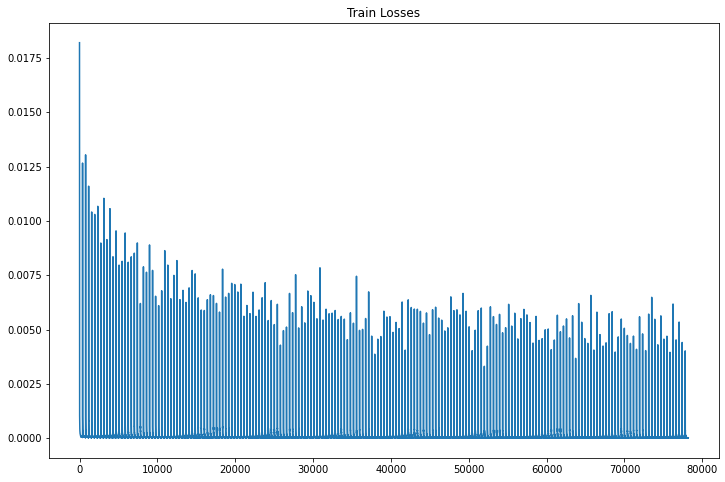

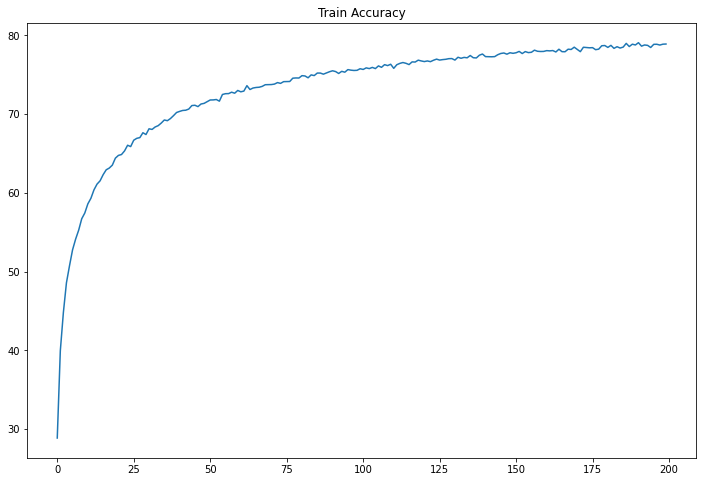

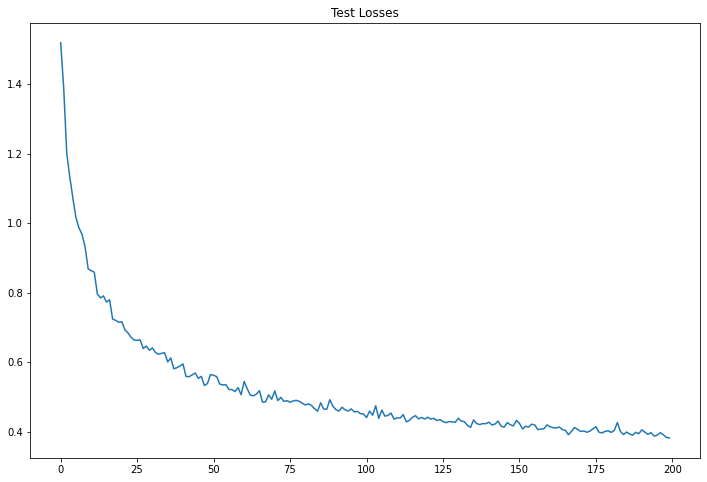

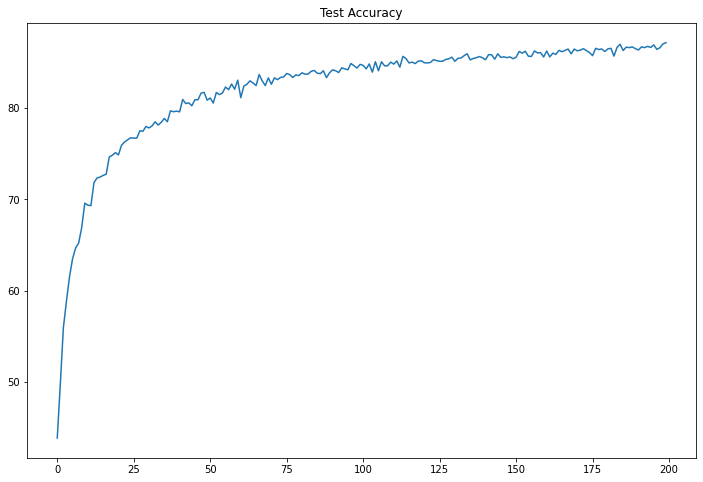

In [44]:
figure = plt.figure(figsize=(12,8))

plt.title(f"Train Losses")
plt.plot(train_stats.losses)

figure = plt.figure(figsize=(12,8))

plt.title(f"Train Accuracy")
plt.plot(train_stats.accuracy)

figure = plt.figure(figsize=(12,8))

plt.title(f"Test Losses")
plt.plot(test_stats.losses)

figure = plt.figure(figsize=(12,8))

plt.title(f"Test Accuracy")
plt.plot(test_stats.accuracy)

In [45]:
def plot_misclassified(test_stats, num_images, title, class_names, fig_size):
    
    figure=plt.figure(figsize=fig_size)
    print(f'** Plotting misclassified test images from last epoch for {title} **')
    print('\n')
    class_names_dict = class_names
    if len(test_stats.img) > num_images: 
        for i in range(num_images):
            plt.subplot(5,5,i+1)
            plt.axis(False)      
            #unnorm_img = unnorm_mispred.unnorm_albumented(test_stats.img[i].cpu())
            unnorm_img = unnormalize(test_stats.img[i].cpu())
            plt.imshow(unnorm_img, interpolation='none')
            prediction = class_names_dict.get(test_stats.pred[i])
            actual     = class_names_dict.get(test_stats.label[i])
            s="pred="+str(prediction)+" act="+str(actual)
            plt.text(2,-1,s)
    else:
        print(f'Unable to plot - Less than {num_images} images, only have {len(test_stats.img)} images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Plotting misclassified test images from last epoch for CIFAR-10 **




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


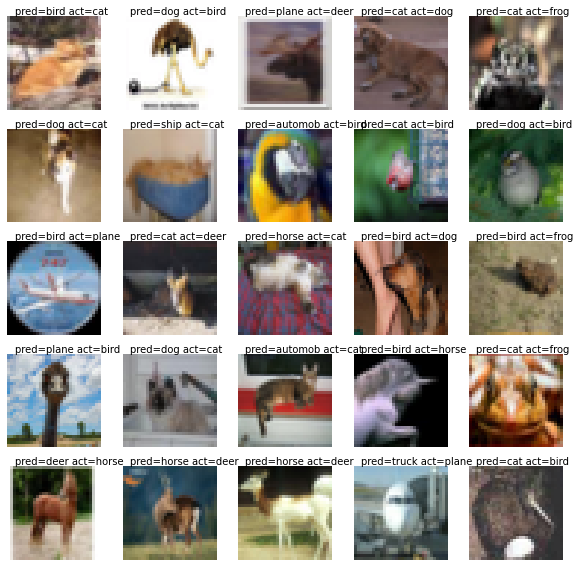

In [46]:
class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
num_images       = 25
fig_size         = (10, 10)
title            = 'CIFAR-10'
misclass_stats   = test_stats
plot_misclassified(misclass_stats, num_images, title, class_names_dict, fig_size)